<br>

#    <center>  EXPLORE Data Science Academy Classification Hackathon</center>
<br>


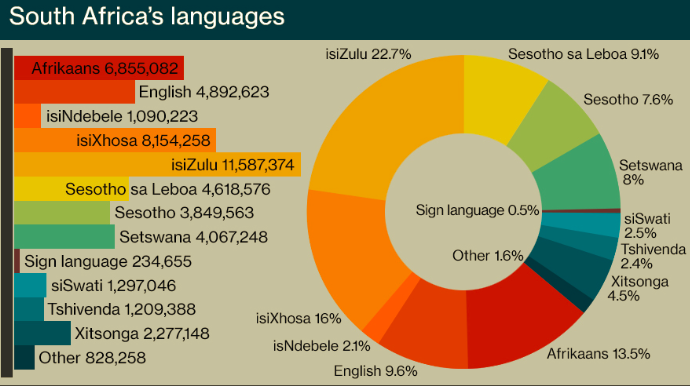

<a id='Table_Contents'></a><br>
### Table of Contents
1. [Introduction](#intro)
 * Overview
 
2. [Data](#imports_data)
 * Running Experiment on Comet
 * Importing Packages
 * Loading Data
 
3. [Exploratory Data Analysis](#EDA)
 * Languages Distribution
 
4. [Data Preprocessing](#preprocessing)
 * Text Cleaning
 * Feature Extraction
 
5. [Model Building and Evaluation](#model)
  
 
6. [Hyperparameter Tuning and Model Validation](#evaluation)
 * Final Model
 




<a id='intro'></a><br>
## 1. Introduction
[Back to Table of Contents](#Table_Contents)

### Overview
South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

<a id='imports_data'></a><br>
## 2. Data
[Back to Table of Contents](#Table_Contents)

### Running Experiment on Comet

In [1]:
# import comet_ml 
#from comet_ml import Experiment

# Create an experiment with your api key
#experiment = Experiment(
    #api_key="g1JQVB0b78cX75nwigIBpE34r",
    #project_name="language-classification",
    #workspace="mainamwangi49",
#)


### Importing Packages


In [1]:
# Loading data
import pandas as pd
import numpy as np
import re
import string

import codecs
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocessing
from sklearn import feature_extraction
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

# Model building
from sklearn import pipeline
from nlppreprocess import NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import warnings
warnings.simplefilter("ignore")

import nltk 
nltk.download('stopwords')

nltk.download('wordnet')
#stop_words = set(stopwords.words('english'))


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False


### Loading Data


We first load the data and inspect its head.

In [2]:
# Loading the Train data set.
train = pd.read_csv('train_set.csv', encoding='UTF-8')

# Loading the test data set.
test = pd.read_csv('test_set.csv' ,encoding='UTF-8')




In [4]:
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [5]:
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.



<a id='EDA'></a><br>
## 3. Exploratory Data Analysis
[Back to Table of Contents](#Table_Contents)


In this section we perform exploratory data analysis on the data to gain a better understanding of the features and the relationships between them. We will employ both statistical and visualisation methods of EDA.

In [3]:
#create a copy of the original data
train_copy = train.copy()
test_copy = test.copy()

In [7]:
#check the number of rows and columns in the train data
train_copy.shape

(33000, 2)

In [8]:
#check the number of rows and columns in the test data
test_copy.shape

(5682, 2)

In [9]:
#check for null values in the train data
train_copy.isnull().sum()

lang_id    0
text       0
dtype: int64

In [10]:
#check for null values in the test data
test_copy.isnull().sum()

index    0
text     0
dtype: int64

Both the train and the test data have no missing values.

### Languages Distribution
The different languages are distributed as follows:

In [11]:
#extract the value counts per sentiment class
count = train_copy.lang_id.value_counts()
#calculate the percentage of each sentiment class
percentage = 100*train_copy.lang_id.value_counts()/len(train_copy.lang_id)
percentage = round(percentage,2)
data = pd.concat([count,percentage],axis =1,)
data.columns = ['Count', 'Percentage']
data

,Count,Percentage
xho,3000,9.09
eng,3000,9.09
nso,3000,9.09
ven,3000,9.09
tsn,3000,9.09
nbl,3000,9.09
zul,3000,9.09
ssw,3000,9.09
tso,3000,9.09
sot,3000,9.09


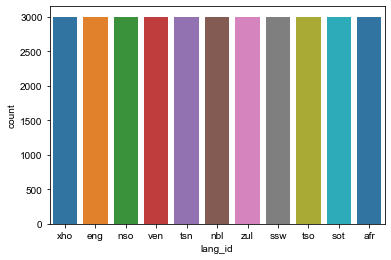

In [12]:
sns.countplot(x='lang_id',data=train_copy,palette='tab10')
sns.set(rc = {'figure.figsize':(9,7)})

From the figure above we observe that the languages have an equal distribution with each having a count of 3000

<a id='preprocessing'></a><br>
## 4. Data Preprocessing
[Back to Table of Contents](#Table_Contents)

This section involves getting rid of data which does not add any value to the languages classification. 



### Text Cleaning
We will remove noise in our data as follows:
- Remove punctuation
- Convert letters to lowercase
- Remove stopwords


In [4]:
# Remove punctuations and convert to lower case
def punct_remover(x):
    x = re.sub(r'[-]',' ',x)
    x = re.sub(r'[_]', ' ', x)
    x = re.sub(r'[^\w\s]','',x)
    x = re.sub('[0-9]+', '', x)
    x = re.sub(r'[^\x00-\x7f]',r'', x)
    x = x.lower()
    return x

#Apply the function to the dataset
train_copy['no_punct'] = train_copy['text'].apply(punct_remover)

In [5]:
# Remove stopwords
stopword = nltk.corpus.stopwords.words('english')
def stopword_remover(x):
    stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    x = stopwords.process(x)
    return x

#Applying the function to the dataset   
train_copy['no_stop'] = train_copy['no_punct'].apply(lambda x: stopword_remover(x))

In [21]:
train_copy.head()

,lang_id,text,no_punct,no_stop
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...,dha iya kuba nobulumko bokubeka umsebenzi naph...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulu natal department of tr...,province kwazulu natal department transport in...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [6]:
def cleaner(df):
    df = punct_remover(df)
    df = stopword_remover(df)
    return df

In [7]:
train_copy['cleaned'] = train_copy['text'].apply(cleaner)
test_copy['cleaned'] = test_copy['text'].apply(cleaner)

### Text Feature Extraction

In [8]:
#split the features from the labels
X = train_copy['cleaned']
y = train_copy['lang_id']


<a id='model'></a><br>
## 5. Model Building and Evaluation
[Back to Table of Contents](#Table_Contents)

We fit several classification models namely logistic regression classifier,  K nearest neighbors classifier, linear SVC, multinomial naive bayes, stochastic gradient descent and the ridge classifier. We split the data into train and test splits and use the train data to fit the models. We then use the test data to evaluate the perfromance of the models.

In [9]:
# Split data into train and test set
X_train , X_test , y_train , y_test = train_test_split(X , y, stratify=y,
                                                       test_size =0.33, 
                                                       random_state=42)

In [57]:
# Create a list of models to be trained
algo = [LogisticRegression(random_state =42 , max_iter=5000) , KNeighborsClassifier(), MultinomialNB(),
        LinearSVC(random_state=42), SGDClassifier(random_state=42), RidgeClassifier(random_state=42)]

In [58]:
# Train the models and record their performance
def performace_evaluation(*args , **kwargs):
  model_stats = {}
  for clf in algo:
    model = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')),
                      ('clf' , clf)
                      ])
    
    model.fit(X_train, y_train) #Training
    model_pred = model.predict(X_test) #Testing

    # Dictionary of Models Performances
    model_stats[clf.__class__.__name__] = {
        'F1-Macro':metrics.f1_score(y_test, model_pred, average='macro'),
        'F1-Accuracy':metrics.f1_score(y_test, model_pred, average='micro'),
        'F1-Weighted':metrics.f1_score(y_test, model_pred, average='weighted')}
  return pd.DataFrame.from_dict(model_stats, orient='index')

In [59]:
# Create model performance comparison table
performance = performace_evaluation(algo , X_train , X_test , y_train , y_test)
performance.to_csv('performance.csv')
dataframe = pd.read_csv('performance.csv', index_col = 0)
dataframe.sort_values('F1-Weighted', ascending=False)

,F1-Macro,F1-Accuracy,F1-Weighted
MultinomialNB,0.999449,0.999449,0.999449
LinearSVC,0.999449,0.999449,0.999449
RidgeClassifier,0.999357,0.999357,0.999357
SGDClassifier,0.999265,0.999265,0.999265
LogisticRegression,0.998439,0.998439,0.998439
KNeighborsClassifier,0.976239,0.976309,0.976239


<a id='evaluation'></a><br>
## 6. Hyperparameter Tuning and Model Validation
[Back to Table of Contents](#Table_Contents)

A hyperparameter is a variable or argument whose value is set before the training process begins. Hyperparameter tuning is the process of choosing a set of optimal hyperparameters for a learning algorithm. Hyperparameter tuning finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given data. We tune the top two models and use them to create a stacked classifier.

In [11]:
Vectorize = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')
X_train = Vectorize.fit_transform(X_train)
X_test = Vectorize.transform(X_test)

In [10]:
model1 = MultinomialNB()

In [11]:
Vectorize = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')
X_train = Vectorize.fit_transform(X_train)
X_test = Vectorize.transform(X_test)

In [12]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True,
                                   random_state=42)

In [13]:
alpha = list(np.linspace(0.1,0.02,4))
param_grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator= model1,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [14]:
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

In [15]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search.best_params_    
grid_search.best_estimator_

Cross-validation score: 0.9997738577029409
Test score: 0.999540863013337


MultinomialNB(alpha=0.1)

In [16]:
model2 = RidgeClassifier()
alpha = list(np.linspace(0.15,0.4, 5))
param_grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator= model2,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [17]:
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

In [18]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search.best_params_    
grid_search.best_estimator_

Cross-validation score: 0.9991406558639785
Test score: 0.9994489891072109


RidgeClassifier(alpha=0.275)

In [21]:
model3 = LinearSVC()
param_grid = {'C': [0.1,1,10,100,1000],
              'max_iter': [10,100],
              'multi_class' : ['crammer_singer', 'ovr'],
              'random_state': [42]} 
grid_search = GridSearchCV(estimator= model3,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [22]:
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)
cv_score = grid_search.best_score_

test_score = grid_search.score(X_test, y_test)

In [23]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search.best_params_    
grid_search.best_estimator_

Cross-validation score: 0.9990503686576299
Test score: 0.9994490816282728


LinearSVC(C=1, max_iter=10, random_state=42)

## Final Model

We create a stacked classifier with MultinomialNB as the estimator and Ridge classifiers as the final estimator.

In [9]:
multiNB1 = MultinomialNB(alpha=0.1)
multiNB2 = MultinomialNB(alpha=0.1)
estimators = [('multiNB1', multiNB1), ('multiNB2', multiNB2)]
final_est = RidgeClassifier(alpha=0.275)

In [10]:
final_model = StackingClassifier(estimators = estimators,
                           final_estimator = final_est,
                           passthrough = True)

In [11]:
vect = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(2, 6), analyzer= 'char')
X_train = vect.fit_transform(X)
y_train = y

In [12]:
final_model.fit(X_train , y_train)

StackingClassifier(estimators=[('multiNB1', MultinomialNB(alpha=0.1)),
                               ('multiNB2', MultinomialNB(alpha=0.1))],
                   final_estimator=RidgeClassifier(alpha=0.275),
                   passthrough=True)

In [13]:
X_test = test_copy['cleaned']
Vectorize = vect.transform(X_test)
test_copy['lang_id'] = final_model.predict(Vectorize)

In [15]:
submission = test_copy[['index', 'lang_id']]
submission.to_csv('Hudson_Maina.csv',index=False)
submission

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot
